In [1]:
import sys
import pathlib
import numpy as np
import pandas as pd
sys.path.insert(0, "../../scripts")
from utils import load_data


from pycytominer.cyto_utils import infer_cp_features


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from sklearn.decomposition import PCA
from tensorflow import keras

from vae import VAE

from tensorflow.keras.models import Model, Sequential
import seaborn
import random as python_random
import tensorflow as tf
import umap

In [2]:
data_splits = ["train", "test", "valid", "complete"]
data_dict = load_data(data_splits)

In [3]:
# Prepare data for training
meta_features = infer_cp_features(data_dict["train"], metadata=True)
cp_features = infer_cp_features(data_dict["train"])

train_features_df = data_dict["train"].reindex(cp_features, axis="columns")
train_meta_df = data_dict["train"].reindex(meta_features, axis="columns")

test_features_df = data_dict["test"].reindex(cp_features, axis="columns")
test_meta_df = data_dict["test"].reindex(meta_features, axis="columns")

valid_features_df = data_dict["valid"].reindex(cp_features, axis="columns")
valid_meta_df = data_dict["valid"].reindex(meta_features, axis="columns")

complete_features_df = data_dict["complete"].reindex(cp_features, axis="columns")
complete_meta_df = data_dict["complete"].reindex(meta_features, axis="columns")


In [4]:
print(train_features_df.shape)
train_features_df.head(3)

(8294, 588)


,Cells_AreaShape_FormFactor,Cells_AreaShape_Orientation,Cells_AreaShape_Zernike_2_2,Cells_AreaShape_Zernike_3_1,Cells_AreaShape_Zernike_5_1,Cells_AreaShape_Zernike_6_2,Cells_AreaShape_Zernike_7_1,Cells_AreaShape_Zernike_7_7,Cells_AreaShape_Zernike_9_3,Cells_Correlation_Correlation_DNA_AGP,...,Nuclei_Texture_SumAverage_AGP_5_0,Nuclei_Texture_SumEntropy_AGP_10_0,Nuclei_Texture_SumEntropy_AGP_20_0,Nuclei_Texture_SumEntropy_AGP_5_0,Nuclei_Texture_SumEntropy_DNA_10_0,Nuclei_Texture_SumEntropy_DNA_20_0,Nuclei_Texture_SumEntropy_Mito_5_0,Nuclei_Texture_SumVariance_DNA_5_0,Nuclei_Texture_Variance_DNA_20_0,Nuclei_Texture_Variance_DNA_5_0
0,0.56071,0.63708,0.57961,0.51030,0.61695,0.30869,0.43981,0.79826,0.72477,0.68589,...,0.17858,0.29336,0.26447,0.30197,0.64786,0.49525,0.53512,0.40495,0.46056,0.43647
1,0.59702,0.55453,0.62561,0.47959,0.59022,0.33269,0.49875,0.88042,0.67159,0.61703,...,0.09030,0.15088,0.13334,0.14052,0.59229,0.49294,0.43221,0.33969,0.39208,0.36205
2,0.64623,0.59825,0.62822,0.52100,0.57452,0.26367,0.48172,0.86322,0.67588,0.69732,...,0.18125,0.23244,0.20723,0.24062,0.54642,0.43920,0.41183,0.30375,0.35385,0.33266


In [5]:
def shuffle_each_column(df):
    columns = df.columns
    df_copy = df.copy()
    for column in columns:
        df_copy[column] = df_copy[column].sample(frac=1).reset_index(drop=True)
    return (df_copy)

In [6]:
train_features_df = shuffle_each_column(train_features_df)
valid_features_df = shuffle_each_column(valid_features_df)

In [7]:
encoder_architecture=[250]
decoder_architecture=[250]

In [9]:
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=10,
    batch_size=96,
    encoder_batch_norm=True,
    epochs=100,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=.3,
    verbose=True,
)
cp_vae.compile_vae()

In [10]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/100
87/87 [==============================] - 3s 9ms/step - loss: 66.7716 - recon: 32.2795 - kl: 1.3604 - val_loss: 17.4317 - val_recon: 15.9406 - val_kl: 1.4912
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 12.3325 - recon: 10.2290 - kl: 1.1995 - val_loss: 11.7245 - val_recon: 10.3306 - val_kl: 1.3939
Epoch 3/100
87/87 [==============================] - 0s 5ms/step - loss: 9.3793 - recon: 7.8080 - kl: 1.0511 - val_loss: 11.4310 - val_recon: 9.3953 - val_kl: 2.0357
Epoch 4/100
87/87 [==============================] - 0s 5ms/step - loss: 7.6802 - recon: 6.5407 - kl: 0.9165 - val_loss: 8.0178 - val_recon: 6.6441 - val_kl: 1.3738
Epoch 5/100
87/87 [==============================] - 0s 5ms/step - loss: 6.8551 - recon: 5.9093 - kl: 0.7959 - val_loss: 7.0278 - val_recon: 5.8753 - val_kl: 1.1525
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 6.3620 - recon: 5.5936 - kl: 0.6947 - val_loss: 6.4748 - val_recon: 5.5534 - val_kl: 0.9214
E

Epoch 99/100
87/87 [==============================] - 0s 5ms/step - loss: 5.2830 - recon: 5.2913 - kl: 1.5678e-04 - val_loss: 5.1773 - val_recon: 5.1771 - val_kl: 1.5103e-04
Epoch 100/100
87/87 [==============================] - 0s 5ms/step - loss: 5.2938 - recon: 5.2935 - kl: 1.3324e-04 - val_loss: 5.1792 - val_recon: 5.1791 - val_kl: 1.2753e-04


In [11]:
cp_vae.vae

In [12]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,val_loss,val_recon,val_kl
0,33.639904,32.279510,1.360405,17.431744,15.940572,1.491172
1,11.428565,10.229024,1.199543,11.724480,10.330583,1.393896
2,8.859108,7.808027,1.051081,11.430956,9.395295,2.035662
3,7.457186,6.540726,0.916461,8.017838,6.644056,1.373781
4,6.705209,5.909305,0.795905,7.027803,5.875301,1.152501
...,...,...,...,...,...,...
95,5.291368,5.291079,0.000288,5.168685,5.168406,0.000279
96,5.292198,5.291957,0.000239,5.170299,5.170070,0.000230
97,5.290346,5.290152,0.000193,5.169592,5.169407,0.000186
98,5.291463,5.291306,0.000157,5.177268,5.177116,0.000151


In [13]:
history_df.to_csv('level5_training_random.csv')

In [14]:
original_training_data  = pd.read_csv('level5_training.csv')

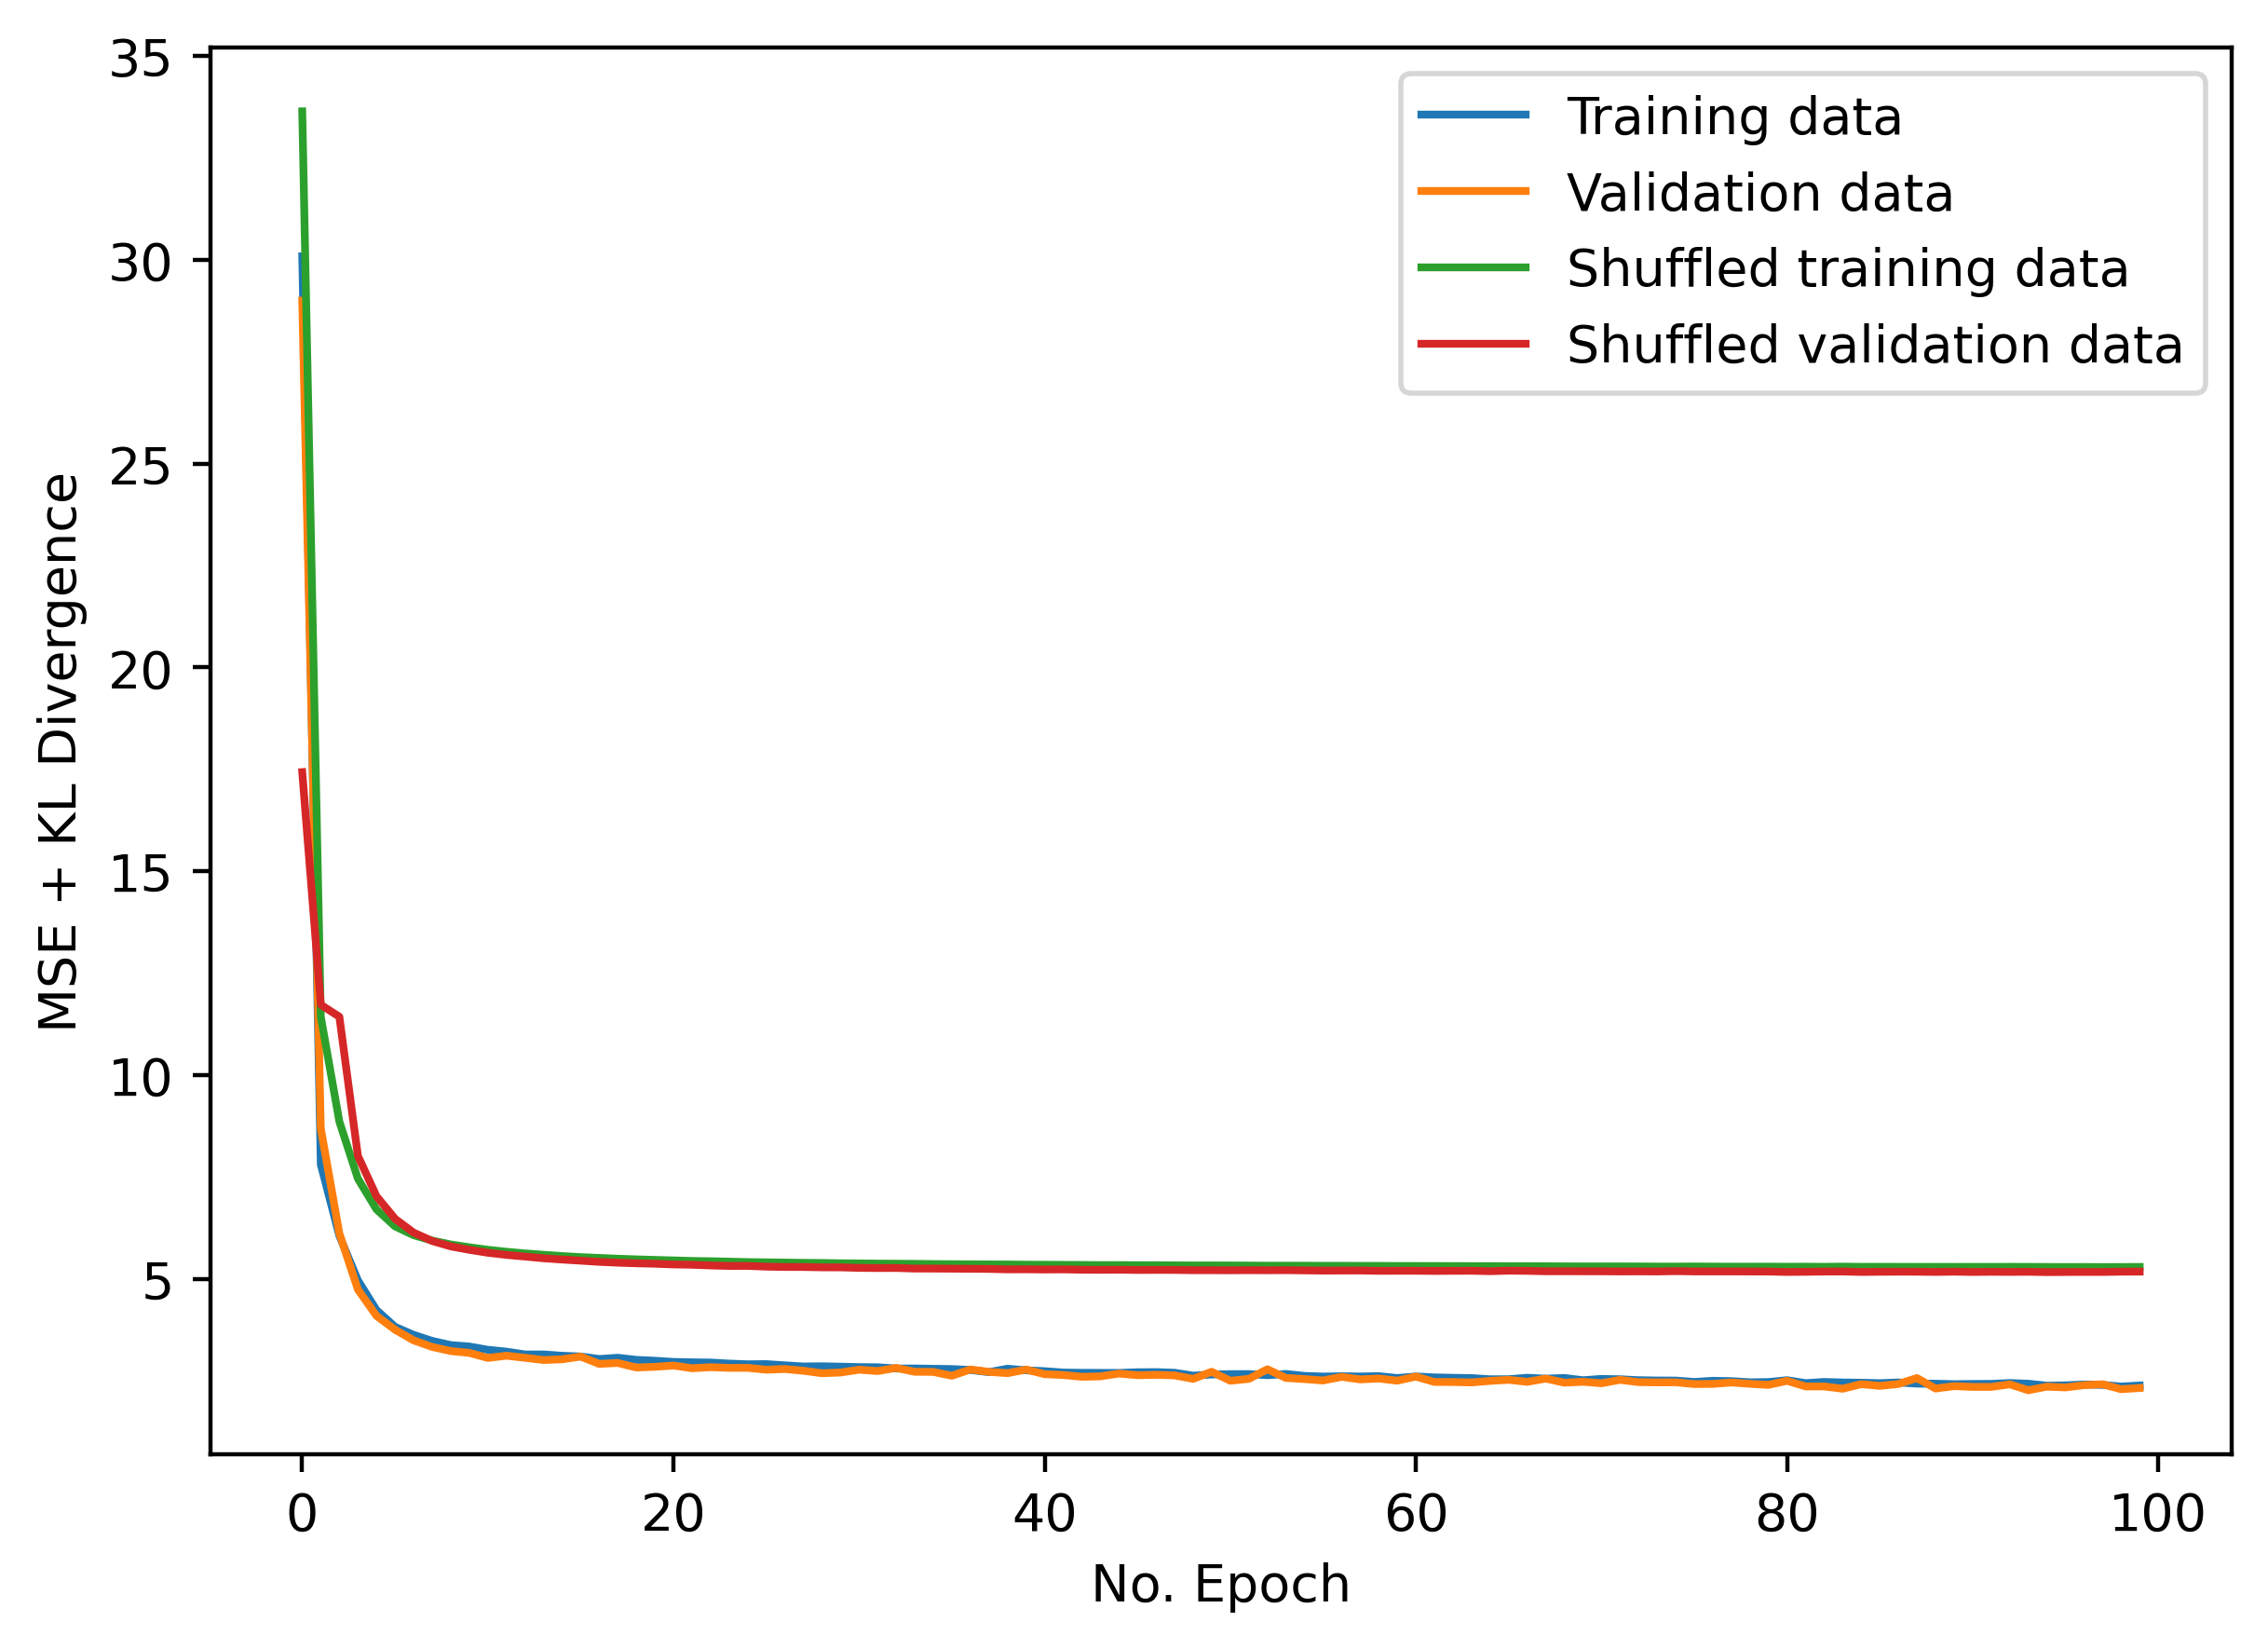

In [22]:
plt.figure(figsize=(7, 5), dpi = 400)
plt.plot(original_training_data["loss"], label="Training data")
plt.plot(original_training_data["val_loss"], label="Validation data")
plt.plot(history_df["loss"], label="Shuffled training data")
plt.plot(history_df["val_loss"], label="Shuffled validation data")
# plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [23]:
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=10,
    batch_size=96,
    encoder_batch_norm=True,
    epochs=100,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=1,
    verbose=True,
)
cp_vae.compile_vae()

In [24]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/100
87/87 [==============================] - 2s 8ms/step - loss: 68.6169 - recon: 31.7185 - kl: 4.4100 - val_loss: 13.5751 - val_recon: 11.7377 - val_kl: 1.8374
Epoch 2/100
87/87 [==============================] - 0s 5ms/step - loss: 14.4885 - recon: 10.0252 - kl: 3.5195 - val_loss: 12.0376 - val_recon: 8.9446 - val_kl: 3.0930
Epoch 3/100
87/87 [==============================] - 0s 5ms/step - loss: 11.1086 - recon: 7.7245 - kl: 2.7614 - val_loss: 12.5672 - val_recon: 8.4262 - val_kl: 4.1410
Epoch 4/100
87/87 [==============================] - 0s 5ms/step - loss: 8.9244 - recon: 6.4462 - kl: 2.1607 - val_loss: 9.9958 - val_recon: 6.5912 - val_kl: 3.4046
Epoch 5/100
87/87 [==============================] - 0s 5ms/step - loss: 7.6843 - recon: 5.8087 - kl: 1.7034 - val_loss: 7.8035 - val_recon: 5.6970 - val_kl: 2.1065
Epoch 6/100
87/87 [==============================] - 0s 5ms/step - loss: 7.0318 - recon: 5.5711 - kl: 1.3643 - val_loss: 7.2045 - val_recon: 5.4677 - val_kl: 1.7368
E

87/87 [==============================] - 0s 5ms/step - loss: 5.2861 - recon: 5.2911 - kl: 7.9158e-06 - val_loss: 5.1668 - val_recon: 5.1668 - val_kl: 8.8209e-06
Epoch 99/100
87/87 [==============================] - 0s 5ms/step - loss: 5.2939 - recon: 5.2913 - kl: 8.7856e-06 - val_loss: 5.1674 - val_recon: 5.1674 - val_kl: 7.7114e-06
Epoch 100/100
87/87 [==============================] - 0s 5ms/step - loss: 5.2996 - recon: 5.2905 - kl: 7.5729e-06 - val_loss: 5.1656 - val_recon: 5.1656 - val_kl: 1.1073e-05


In [25]:
cp_vae.vae

In [26]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,val_loss,val_recon,val_kl
0,36.128571,31.718523,4.410039,13.575115,11.737711,1.837404
1,13.544679,10.025165,3.519510,12.037576,8.944620,3.092957
2,10.485960,7.724512,2.761449,12.567165,8.426210,4.140953
3,8.606905,6.446236,2.160669,9.995753,6.591167,3.404586
4,7.512143,5.808716,1.703425,7.803478,5.696989,2.106489
...,...,...,...,...,...,...
95,5.290918,5.290912,0.000008,5.171152,5.171144,0.000007
96,5.291558,5.291549,0.000008,5.165928,5.165919,0.000009
97,5.291096,5.291090,0.000008,5.166814,5.166804,0.000009
98,5.291295,5.291286,0.000009,5.167432,5.167425,0.000008


In [27]:
history_df.to_csv('level5_training_vanilla_random.csv')

In [28]:
original_training_data  = pd.read_csv('level5_training_vanilla.csv')

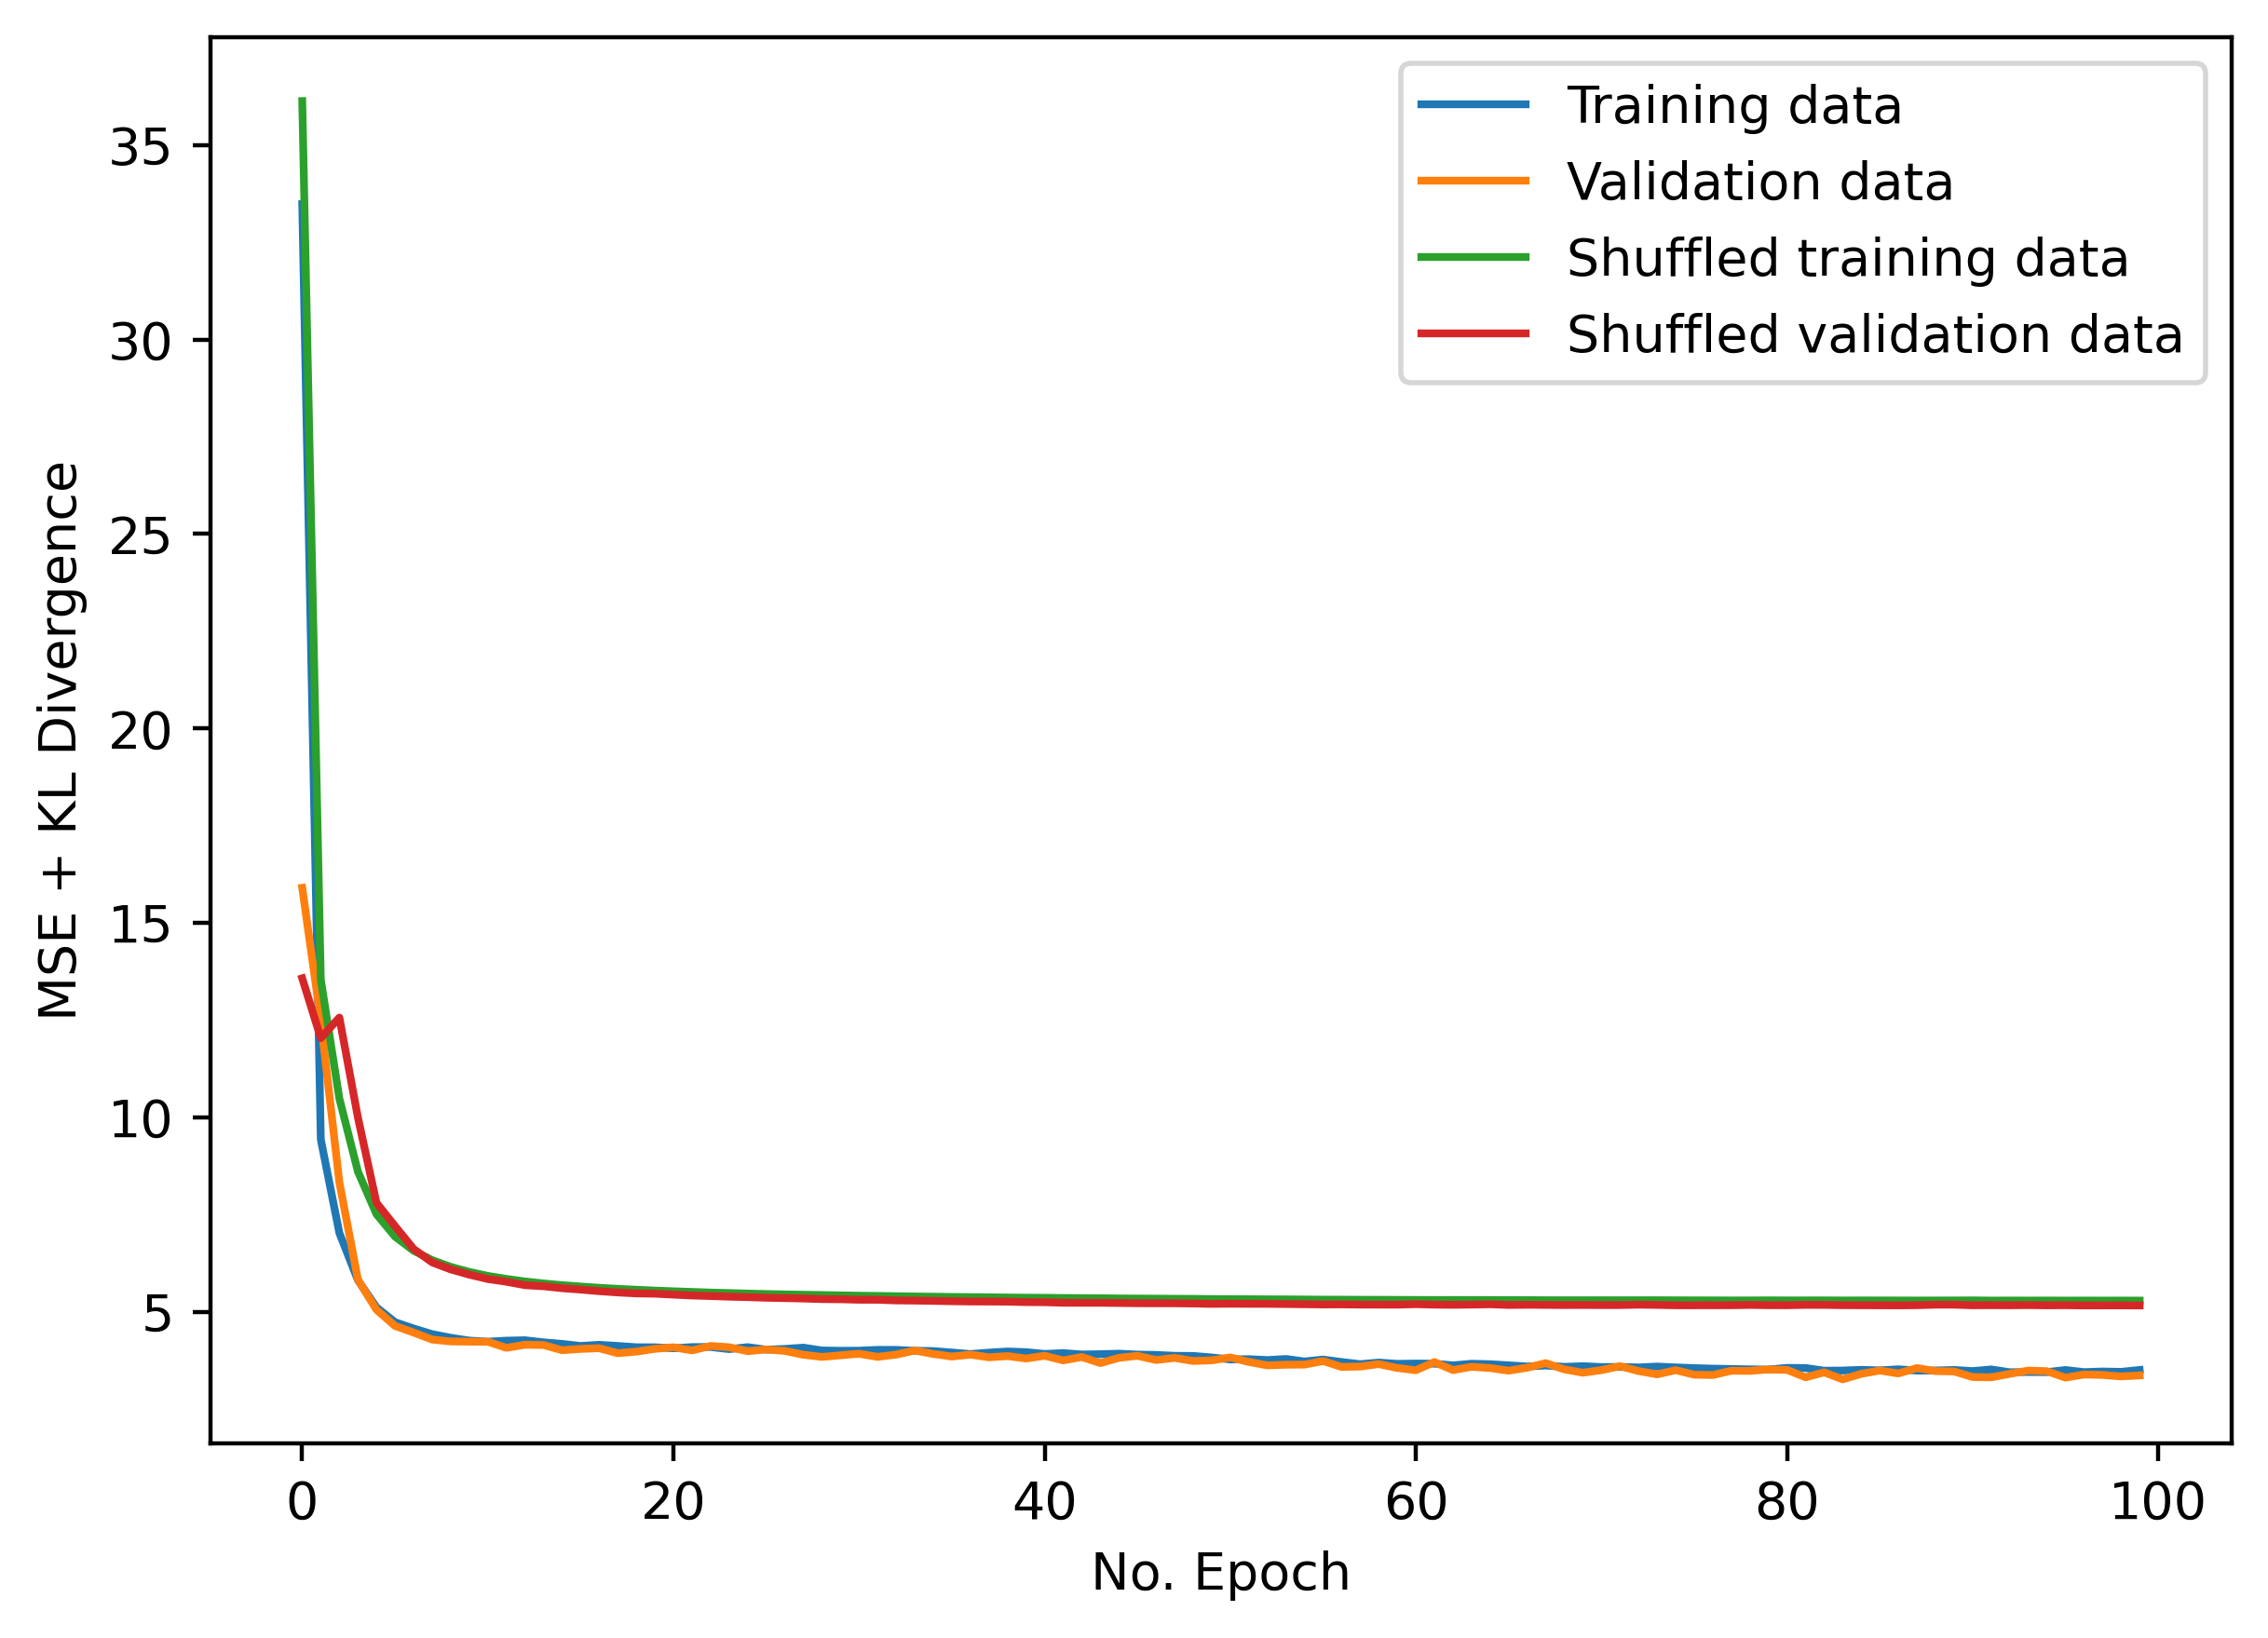

In [29]:
plt.figure(figsize=(7, 5), dpi = 400)
plt.plot(original_training_data["loss"], label="Training data")
plt.plot(original_training_data["val_loss"], label="Validation data")
plt.plot(history_df["loss"], label="Shuffled training data")
plt.plot(history_df["val_loss"], label="Shuffled validation data")
# plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()

In [8]:
cp_vae = VAE(
    input_dim=train_features_df.shape[1],
    latent_dim=10,
    batch_size=96,
    encoder_batch_norm=True,
    epochs=30,
    learning_rate=0.001,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=0,
    lam=1000,
    verbose=True,
)
cp_vae.compile_vae()

In [9]:
cp_vae.train(x_train=train_features_df, x_test=valid_features_df)

Epoch 1/30
87/87 [==============================] - 4s 16ms/step - loss: 86.5158 - recon: 32.1844 - kl: 0.0000e+00 - mmd: 20.3875 - val_loss: 45.5967 - val_recon: 10.4002 - val_kl: 0.0000e+00 - val_mmd: 36.3440
Epoch 2/30
87/87 [==============================] - 0s 6ms/step - loss: 25.7323 - recon: 10.3492 - kl: 0.0000e+00 - mmd: 13.0079 - val_loss: 66.8104 - val_recon: 7.9836 - val_kl: 0.0000e+00 - val_mmd: 59.4309
Epoch 3/30
87/87 [==============================] - 0s 6ms/step - loss: 17.6485 - recon: 7.7143 - kl: 0.0000e+00 - mmd: 9.6812 - val_loss: 82.6477 - val_recon: 10.0538 - val_kl: 0.0000e+00 - val_mmd: 72.3710
Epoch 4/30
87/87 [==============================] - 1s 6ms/step - loss: 13.1924 - recon: 6.4010 - kl: 0.0000e+00 - mmd: 6.8016 - val_loss: 99.2119 - val_recon: 9.5555 - val_kl: 0.0000e+00 - val_mmd: 89.5234
Epoch 5/30
87/87 [==============================] - 0s 6ms/step - loss: 11.6383 - recon: 5.8405 - kl: 0.0000e+00 - mmd: 5.9646 - val_loss: 56.1865 - val_recon: 5.933

In [10]:
cp_vae.vae

In [11]:
# Save training performance
history_df = pd.DataFrame(cp_vae.vae.history.history)
history_df

,loss,recon,kl,mmd,val_loss,val_recon,val_kl,val_mmd
0,51.999298,32.184414,0.0,20.387451,45.596691,10.400178,0.0,36.343956
1,23.383968,10.349192,0.0,13.007919,66.810394,7.983624,0.0,59.430912
2,16.899988,7.714281,0.0,9.681236,82.647720,10.053767,0.0,72.371002
3,12.928531,6.400963,0.0,6.801589,99.211914,9.555476,0.0,89.523438
4,11.440209,5.840486,0.0,5.964562,56.186546,5.933044,0.0,46.585083
5,10.339021,5.579319,0.0,4.976361,18.813459,5.516579,0.0,12.093219
6,9.793732,5.464540,0.0,4.243262,114.796837,5.667677,0.0,111.176788
7,9.593639,5.410128,0.0,4.279030,38.026440,5.332070,0.0,32.417427
8,9.717597,5.379438,0.0,4.070230,16.653605,5.262033,0.0,13.586208
9,9.547585,5.362324,0.0,4.134573,44.307915,5.275727,0.0,40.596966


In [12]:
history_df.to_csv('level5_training_mmd_random.csv')

In [13]:
original_training_data  = pd.read_csv('level5_training_mmd.csv')

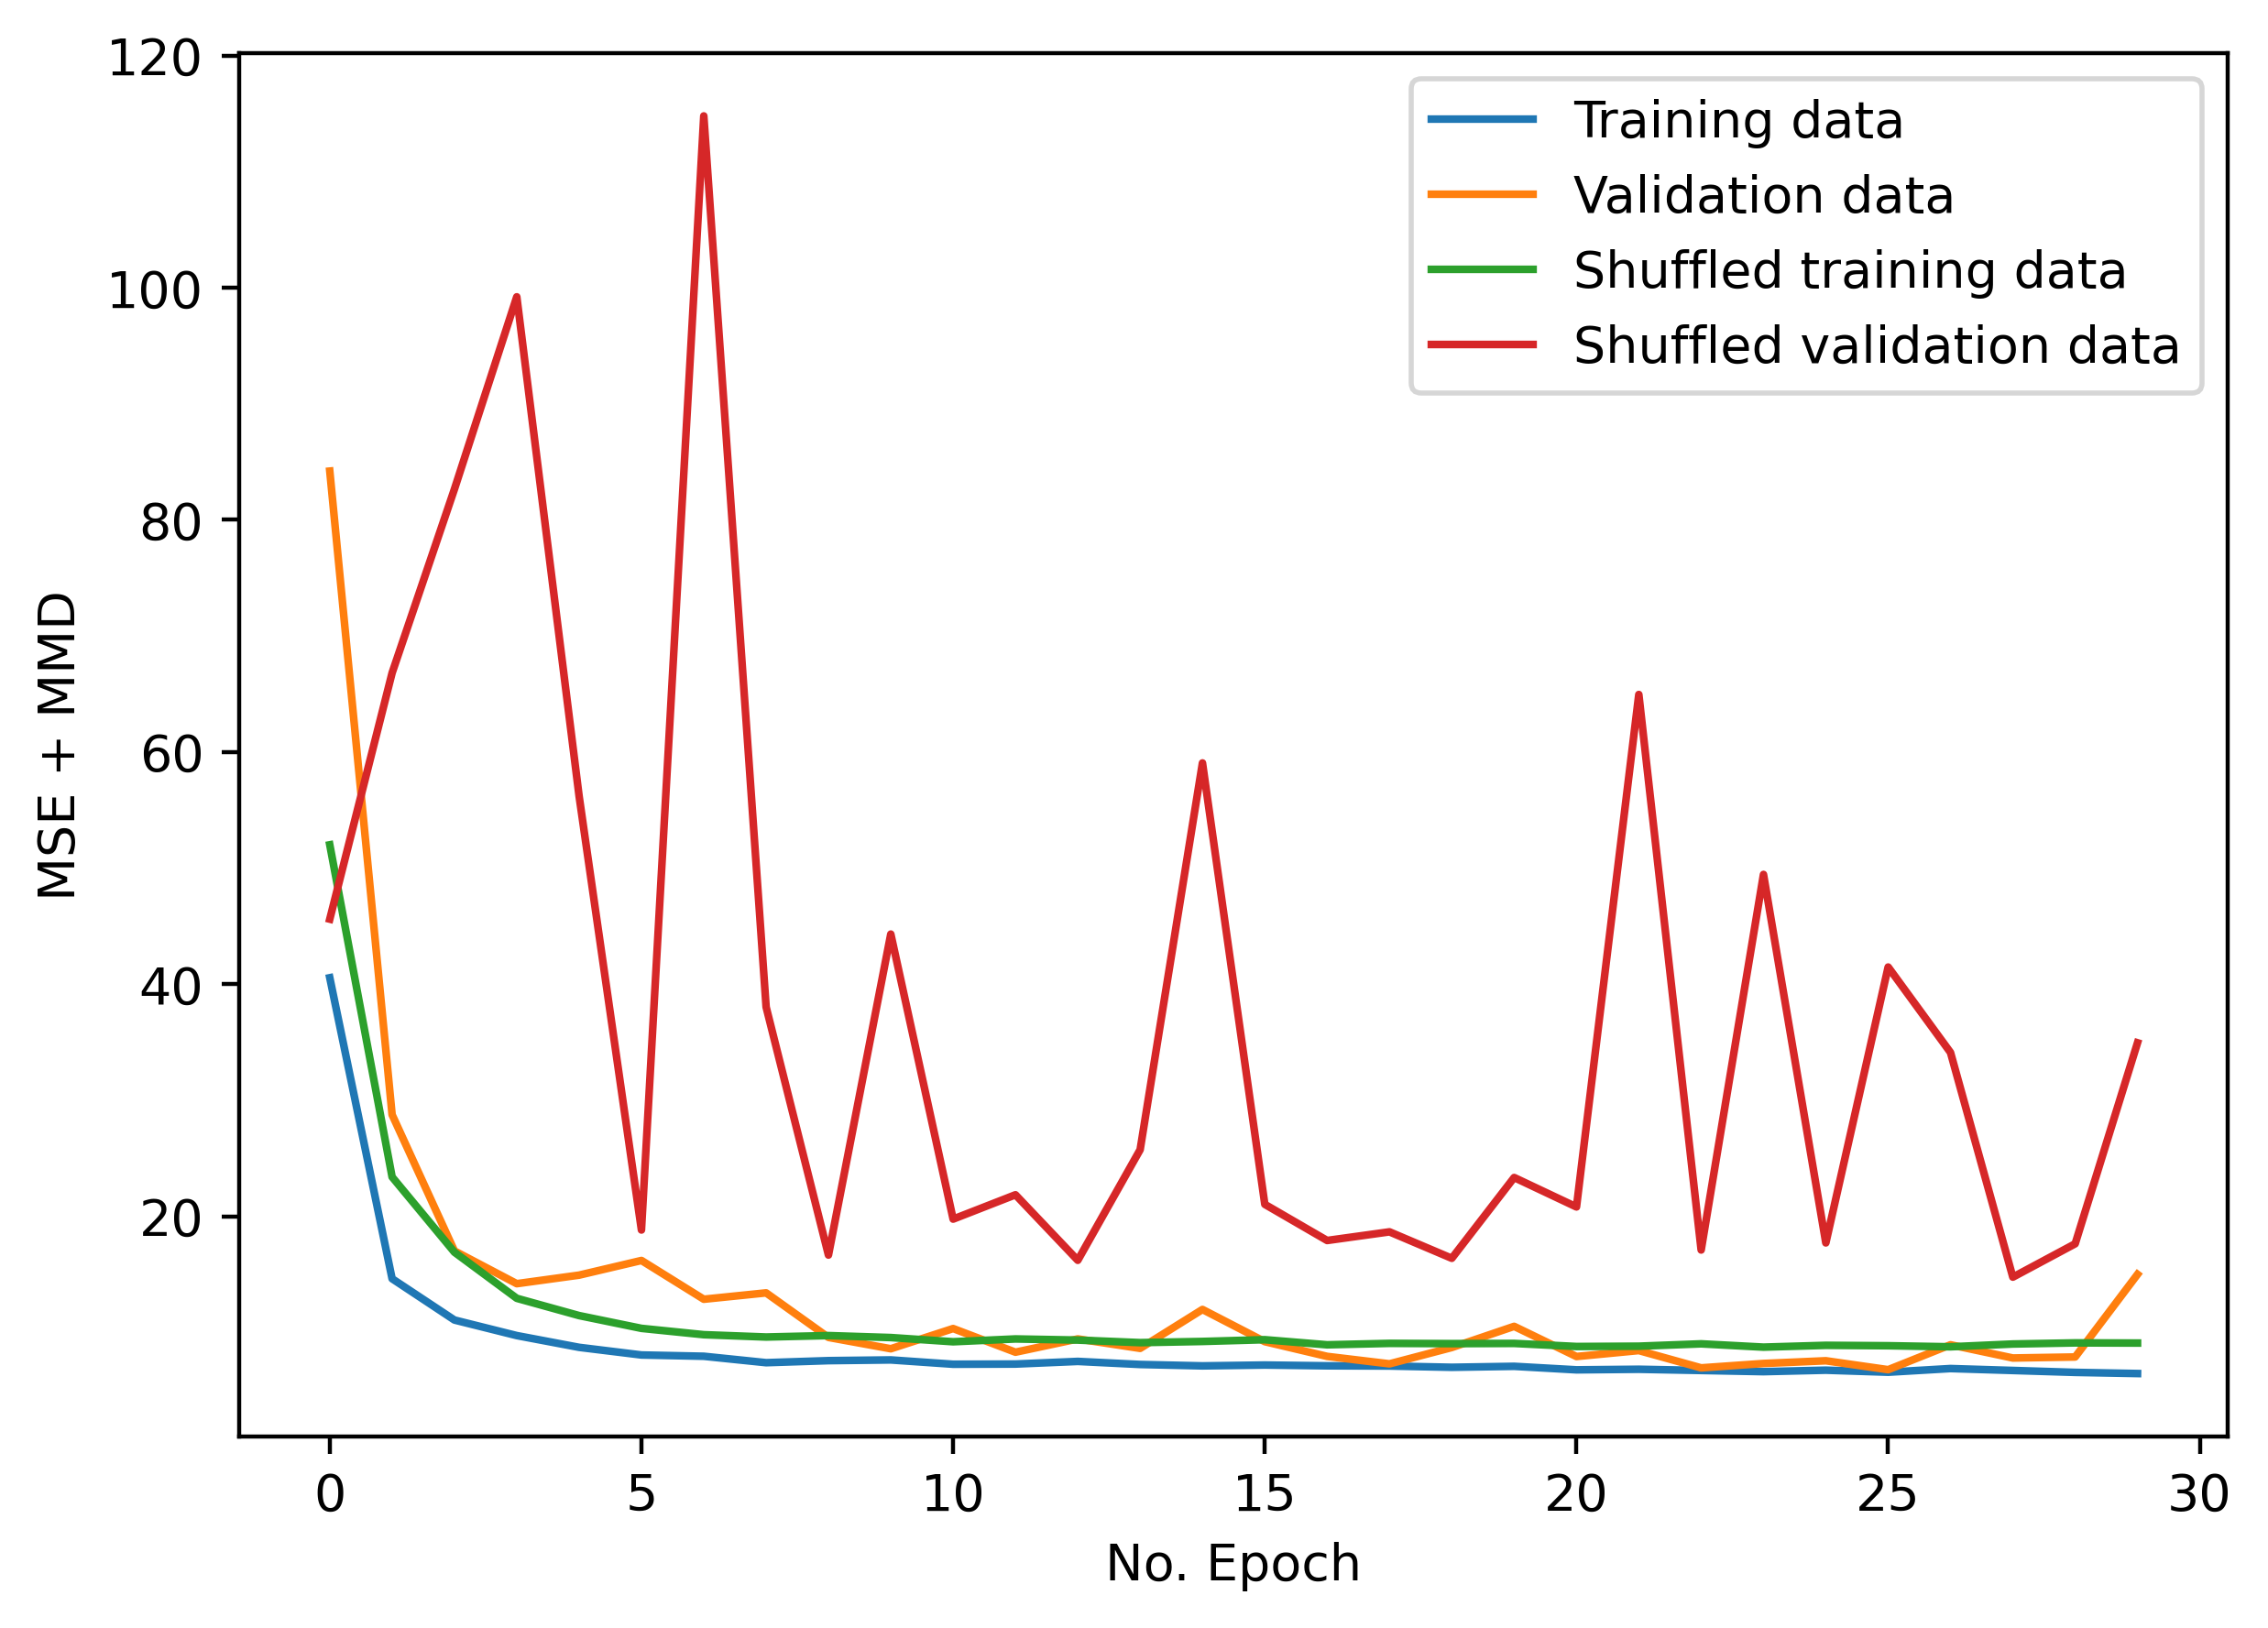

In [14]:
plt.figure(figsize=(7, 5), dpi = 400)
plt.plot(original_training_data["loss"], label="Training data")
plt.plot(original_training_data["val_loss"], label="Validation data")
plt.plot(history_df["loss"], label="Shuffled training data")
plt.plot(history_df["val_loss"], label="Shuffled validation data")
# plt.title("Loss for VAE training on Cell Painting Level 5 data")
plt.ylabel("MSE + MMD")
plt.xlabel("No. Epoch")
plt.legend()
plt.show()